In [1]:
import os
import csv
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import sqlalchemy
from sqlalchemy import Column, Float, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base

In [2]:
engine = create_engine('sqlite:///hawaii.sqlite')
conn = engine

In [3]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
#map classes w/names matching that of the tablename
Station = Base.classes.station
Measurement = Base.classes.measurement
session = Session(engine)

In [5]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
dt_object1 = dt.datetime.strptime(*latest_date, "%Y-%m-%d")
dt_object2 = dt.datetime.date(dt_object1) - dt.timedelta(days=365)
oldest_date = dt.datetime.strftime(dt_object2, "%Y-%m-%d")

In [6]:
prcp_data = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
                           filter(Measurement.date >= oldest_date).order_by(Measurement.date).all()

In [7]:
prcp_df = pd.DataFrame(prcp_data, columns = ["station", "date", "prcp", "tobs"])
prcp_date_df = prcp_df[["date", "prcp"]]
pd.to_datetime(prcp_date_df['date'])
prcp_date_df.set_index(["date"], inplace=True)

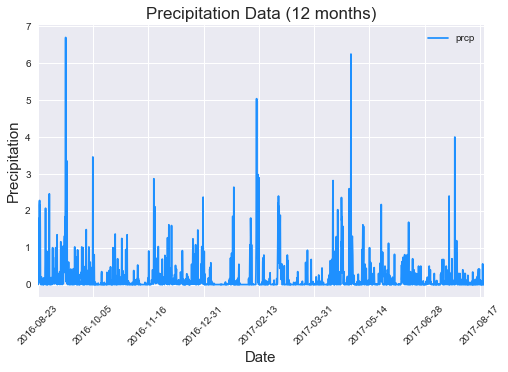

In [8]:
precip_df = prcp_date_df.plot(figsize=(8,5), color="dodgerblue", rot=45)
precip_df.set_title("Precipitation Data (12 months)", fontsize=17)
precip_df.set_ylabel("Precipitation", fontsize=15)
precip_df.set_xlabel("Date", fontsize=15)
plt.savefig("Precipitation Data.png")
plt.show()

In [9]:
stats = prcp_date_df.describe()
stats.to_csv("Precipitation Statistics.csv")
print('Precipitation Data Statistics') 
print(stats)

Precipitation Data Statistics
              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


In [10]:
total_stations = session.query(func.count(Station.station)).all()
print('Total number of stations is')          
print(*total_stations[0])

Total number of stations is
9


In [11]:
active_station = session.query(Measurement.station, Measurement.tobs).group_by(Measurement.station).\
                  order_by(Measurement.tobs.desc()).first()
print(f'The most active station is {active_station[0]} with a total of {active_station[1]} stations')

The most active station is USC00514830 with a total of 82 stations


In [12]:
tobs_data = session.query(Measurement.tobs).\
                           filter((Measurement.date >= oldest_date) & (Measurement.date <= latest_date[0])).\
                           order_by(Measurement.tobs.desc()).all()        

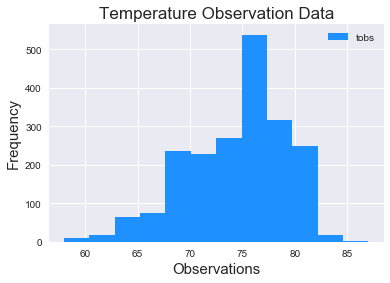

In [13]:
tobs_data_df = pd.DataFrame(tobs_data, columns = ["tobs"])
tobs_df = tobs_data_df.plot(kind="hist", bins=12, facecolor ="dodgerblue")
tobs_df.set_title("Temperature Observation Data", fontsize=17)
tobs_df.set_xlabel("Observations", fontsize=15)
tobs_df.set_ylabel("Frequency", fontsize=15)
plt.savefig("Temperature Observation Data.png")
plt.show()

In [14]:
def calc_temps(s_dt, e_dt):
    
    s_dt_obj1 = dt.datetime.strptime(s_dt, "%Y-%m-%d")
    s_dt_obj2 = dt.datetime.date(s_dt_obj1) - dt.timedelta(days=365)
    start_date = dt.datetime.strftime(s_dt_obj2, "%Y-%m-%d") 
    
    e_dt_obj1 = dt.datetime.strptime(e_dt, "%Y-%m-%d")
    e_dt_obj2 = dt.datetime.date(e_dt_obj1) - dt.timedelta(days=365)
    end_date = dt.datetime.strftime(e_dt_obj2, "%Y-%m-%d") 
    
    temp_avg = session.query(func.avg(Measurement.tobs)).\
                           filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).all()
    temp_min = session.query(func.min(Measurement.tobs)).\
                           filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).all()
    temp_max = session.query(func.max(Measurement.tobs)).\
                           filter((Measurement.date >= start_date) & (Measurement.date <= end_date)).all()
  
    return(*temp_avg[0], *temp_min[0], *temp_max[0])
    

In [15]:
st_date = '2018-06-01'
en_date = "2018-06-15"
temp_data = calc_temps(st_date, en_date)

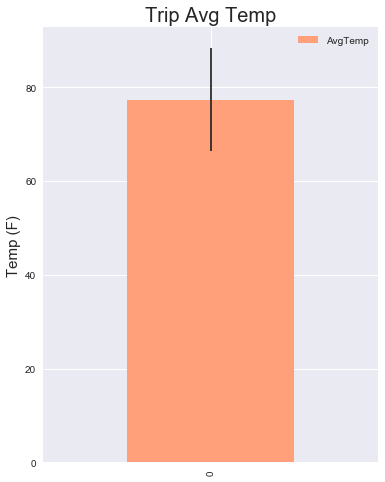

In [16]:
temp_data_df = pd.DataFrame({"AvgTemp":[temp_data[0]]})
temp_diff = temp_data[2] - temp_data[1]
trip_plot = temp_data_df.plot(kind="bar", yerr= [temp_diff], facecolor="lightsalmon", figsize=(6,8))
trip_plot.set_title("Trip Avg Temp", fontsize=20)
trip_plot.set_ylabel("Temp (F)", fontsize=15)
plt.savefig("Trip Avg Temp.png")
plt.show()